In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp
%matplotlib inline
from tqdm.auto import tqdm
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

### "Хороший" студент :  относительное количество работ, проверенных более, чем за n часов < 0.1
### Студенты "первого" рода:  "хорошие" студенты, которые не закончили курс
### Студенты "второго" рода:  "плохие" студенты, которыеё закончили курс

In [60]:
def magic(date):
    date = date[:4]+' '+date[5:7]+' '+date[8:]       
    return date[:18]

def q_9(x):
    return np.quantile(x, 0.9) 
def prepare_dataframe(folder,course_id,subject=None):
    
    """
    возвращает таблицу с колонками: element_progress_id, hours_diff, user_id, module_is_achieved, 
                                    size_of_answer, size_of_review, rewiew_time, course_element_id
                                    id from solution_log
    """
    if subject is None:
        path = f'{folder}/{course_id}/'
    else:
        path = f'{folder}/{subject}/{course_id}/'
    try:
        solution_log = pd.read_csv(path+'solution_log.csv')
    except:
        raise Exception(f'No such file or directory',path,'solution_log.csv')
    
    
    solution_log['size_of_answer'] = solution_log['users_answer'].apply(lambda x: len(str(x)))
    solution_log['size_of_review'] = solution_log['review'].apply(lambda x: len(str(x)))

    solution_log = solution_log.dropna(subset=['review_time'])
    solution_log = solution_log.reset_index(drop=True)
    
    ###
    difference = []
    for i in range(len(solution_log['review_time'])):
        a = datetime.strptime(magic(solution_log['submission_time'][i]), '%Y %m %d %H:%M:%S')
        b = datetime.strptime(magic(solution_log['review_time'][i]), '%Y %m %d %H:%M:%S')
        difference.append(b - a)
    solution_log['time_of_expectation'] = difference
    solution_log = solution_log.drop(columns=['submission_time'])
    ###
    
    solution_log['hours_diff']=solution_log['time_of_expectation'].apply(lambda x: x.days*24+x.seconds//3600)
    pre_df = solution_log[['element_progress_id','hours_diff', 'size_of_answer', 'size_of_review', 'tries_count', 'review_time']]
    pre_df['id_from_sl'] = solution_log['id']
    pre_df['id']=pre_df['element_progress_id'].astype(int)
    ##pre_df = pre_df.drop(columns=['element_progress_id'])
    try:
        user_element_progress = pd.read_csv(path+'user_element_progress.csv')
    except:
        raise Exception(f'No such file or directory',path,'user_element_progress.csv')
    user_element_progress['id'] = user_element_progress['id'].astype(int)
    user_element_progress.reset_index(drop=True)
    user_element_progress = user_element_progress[['id','user_id', 'course_element_id']]
    
    try:
        user_module_progress = pd.read_csv(path+'user_module_progress.csv')
    except:
        raise Exception(f'No such file or directory',path,'user_module_progress.csv')
    user_module_progress['is_achieved'] = user_module_progress['is_achieved'].fillna(False).astype(int)
    user_module_progress = user_module_progress[['user_id','course_module_id','is_achieved']]
    
    df = pre_df.merge(user_element_progress).merge(user_module_progress, on='user_id')
    return df
def magic(date):
    date = date[:4]+' '+date[5:7]+' '+date[8:]       
    return date[:18]

def hours_criterion(subject,course_id,h_start=0, h_end=96,df=None, show_good_bad=True, id_col='unique_id',fraction = 0.1):
    """
    Построение графика относитльно часов
    """
    if df is None:
        df = prepare_dataframe(subject, course_id)
    if h_start>=h_end:
        raise Exception(f'h_start>=h_end')
    
    hours = np.arange(h_start,h_end)
    if show_good_bad:
        good = []
        bad = []
    I_error = []
    II_error = []
    for h in tqdm(hours):
        if show_good_bad: 
            g = 0
            b = 0
        I_type = 0
        II_type = 0
        for u_id in df[id_col].unique():
            total = len(df[df[id_col]==u_id])
            greater =  sum((df[df[id_col]==u_id]['hours_diff']>=h))/total
            if show_good_bad:
                if greater<fraction and df[df[id_col]==u_id]['is_achieved'].iloc[0]==1: 
                    g+=1
                else:
                    b+=1
            if greater<fraction and df[df[id_col]==u_id]['is_achieved'].iloc[0]==0:
                I_type+=1   
            elif greater>=fraction and df[df[id_col]==u_id]['is_achieved'].iloc[0]==1:
                II_type+=1
            
        I_error.append(I_type)
        II_error.append(II_type)
        if show_good_bad:
            good.append(g)
            bad.append(b)
    
    total_passed = df.groupby(id_col)['is_achieved'].min().sum()
    total_students = len(df[id_col].unique())
    not_w_error = max(I_error)+max(II_error)
    w_error = not_w_error
    not_w_h = None
    w_h = None
    for i in range(len(hours)):
        #проверка, что никакая из ошибок не равна 1/0(в абсолютном значении)
        if (I_error[i]!=total_students-total_passed and II_error[i]!=total_passed) and  (II_error[i]!=0 and I_error[i]!=0): 
            if I_error[i]+II_error[i]<not_w_error:
                not_w_error=I_error[i]+II_error[i]
                not_w_h = hours[i]
            if I_error[i]/(total_students-total_passed)+II_error[i]/total_passed<w_error:
                w_error=I_error[i]/(total_students-total_passed)+II_error[i]/total_passed
                w_h = hours[i]
    print(f"Минимальное время проверки: {df['hours_diff'].min()} часов, максимальное время проверки {df['hours_diff'].max()} часов")
    print(f'Лучшее "невзвешенное" время: {not_w_h} (ошибка {not_w_error}, из них {I_error[not_w_h]} первого рода),'
                     f' лучшее взвешенное время: {w_h} (ошибка {w_error}, из этого {I_error[w_h]/(total_students-total_passed)} первого рода ({I_error[w_h]})')
    print(f'Ошибка для {hours[48]} часов: {I_error[48]+II_error[48]}, из них {I_error[48]} первого рода,  взвешенная: {I_error[48]/(total_students-total_passed)+II_error[48]/total_passed}' )
    I_error = np.array(I_error)/(total_students-total_passed) 
    II_error = np.array(II_error)/total_passed
    if show_good_bad:
        good = np.array(good)/total_passed
        bad = np.array(bad)/(total_students-total_passed)
    
    fig, axis = plt.subplots(1,1,figsize=(20,7))
    if show_good_bad:
        axis.plot(hours, bad, label='"bad" students',color='r')
        axis.plot(hours, good, label = '"Good" students', color='g')
    
    axis.plot(hours, I_error, label ='"I type error" students')
    axis.plot(hours, II_error, label = '"II type error" students')

    axis.vlines(48,0,1,'black', label = '48 hours')
    axis.vlines(w_h,0,1,'cyan', label = 'best weighted')
    axis.vlines(not_w_h,0,1,'purple', label = 'best not weighted')
    plt.legend(fontsize=14)
    axis.set_title(f'{subject}-{course_id}')
    axis.set_xlabel('hours')
    axis.set_ylabel('relative amount')
    plt.figtext(0.5, -0.1, f"{fraction*100}-квантиль\nПо оси y отложена нормированная ошибка, по оси x количество часов.")
    plt.show()
    
    
def fraction_criterion(subject,course_id,f_start=0, f_end=1.1, step=0.05):
    """
    Построение графика относитльно доли работ, проверенных больше, чем за 48 часов
    """
    df = prepare_dataframe(subject, course_id)
    if f_start>=f_end:
        raise Exception(f'f_start>=f_end')
    fractions = np.arange(f_start,f_end,step)
    good = []
    I_error = []
    II_error = []
    bad = []
    for f in tqdm(fractions):
        g = 0
        I_type = 0
        II_type = 0
        b = 0
        for u_id in df['user_id'].unique():
            total = len(df[df['user_id']==u_id])
            greater =  sum((df[df['user_id']==u_id]['hours_diff']>=48))/total
            if greater<f and df[df['user_id']==u_id]['is_achieved'].iloc[0]==1: 
                g+=1
            elif greater<f and df[df['user_id']==u_id]['is_achieved'].iloc[0]==0:
                I_type+=1   
            elif greater>=f and df[df['user_id']==u_id]['is_achieved'].iloc[0]==1:
                II_type+=1
            else:
                b+=1
        good.append(g)
        I_error.append(I_type)
        II_error.append(II_type)
        bad.append(b)
    
    total_passed = df.groupby(['user_id'])['is_achieved'].min().sum()
    total_students = len(df['user_id'].unique())
    good = np.array(good)/total_passed
    I_error = np.array(I_error)/(total_students-total_passed) 
    II_error = np.array(II_error)/total_passed
    bad = np.array(bad)/(total_students-total_passed)
    fig, axis = plt.subplots(1,1,figsize=(20,7))
    axis.plot(fractions, good, label = '"Good" students', color='g')
    axis.plot(fractions, I_error, label ='"I type error" students')
    axis.plot(fractions, II_error, label = '"II type error" students')
    axis.plot(fractions, bad, label='"bad" students',color='r')
    plt.legend(fontsize=14)
    axis.set_title(f'{subject}-{course_id}')
    axis.set_xlabel('fraction')
    axis.set_ylabel('relative amount')
    plt.show()

### $ \{T_{i} > t \text{ часов } \} \le 0.1 $

  0%|          | 0/72 [00:00<?, ?it/s]

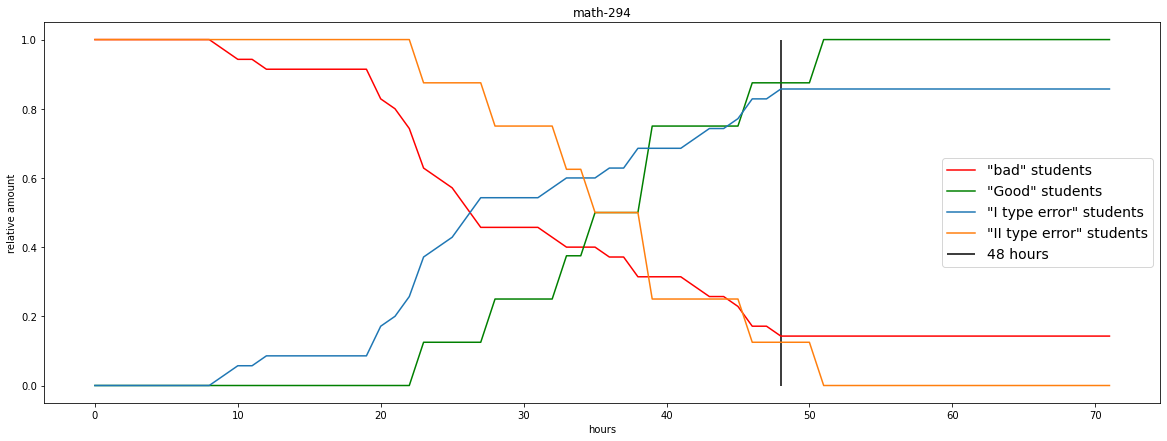

Минимальное время проверки: 0 часов, максимальное время проверки 274 часов


In [32]:
hours_criterion('math','294',0, 72)

### $ \{T_{i} \ge 48 \text{ часов } \} < f $

100%|██████████| 22/22 [00:02<00:00, 10.43it/s]


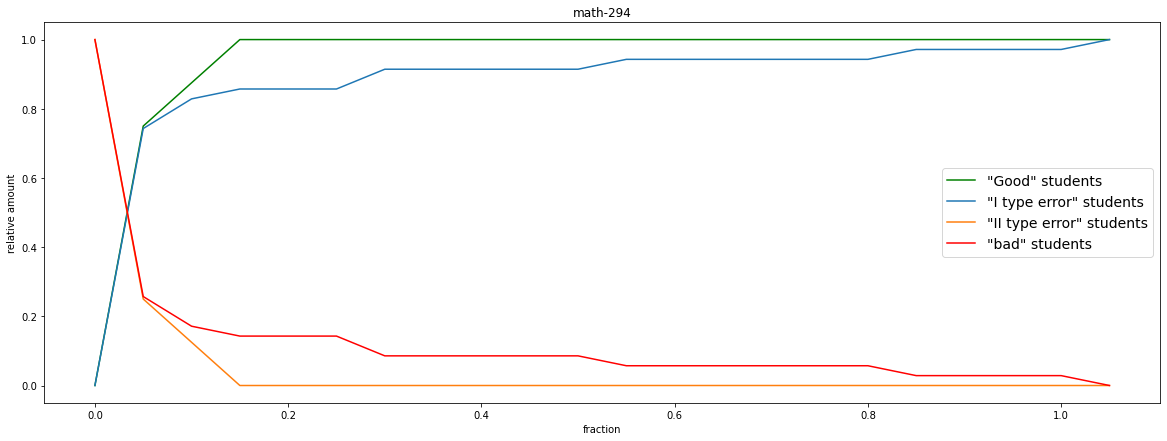

In [3]:
fraction_criterion('math','294')

## Неполные данные


In [3]:
subjects = ['math','physics','linguo']
coursers = [['293','294','295'], ['345','346'],['267','268']]
df = pd.DataFrame()
for s in enumerate(subjects):
        for c in coursers[s[0]]:
            tmp_df = prepare_dataframe(s[1],c)
            for i in tmp_df['user_id'].unique():
                try:
                    if i in df['user_id'].unique():
                        print('Alarm',i,s[1],c)
                except:
                    pass
            df=df.append(tmp_df,ignore_index=True)
df

Alarm 100120090110736982 physics 345


,hours_diff,user_id,is_achieved
0,33,100119750111014140,0
1,21,100119750111014140,0
2,43,100119750111014140,0
3,21,100119750111014140,0
4,22,100119750111014140,0
...,...,...,...
8850,14,100120030110010958,0
8851,22,100120030110010958,0
8852,43,100120040110672072,0
8853,3,100120040110672072,0


In [5]:
df[df['user_id']==100120090110736982]['is_achieved'].value_counts()

0    58
Name: is_achieved, dtype: int64

In [35]:
len(df['user_id'].unique())

300

In [32]:
df.groupby(['is_achieved']).agg({"user_id": "nunique"})

,user_id
is_achieved,
0,205
1,95


In [ ]:
hours_criterion('All','coursers',df=df)

100%|██████████| 96/96 [00:37<00:00,  2.55it/s]


Минимальное время проверки: 0 часов, максимальное время проверки 2536 часов
Лучшее "невзвешенное" время: 16 (ошибка 121, из них 27 первого рода), лучшее взвешенное время: 88 (ошибка 1.0572528883183567, из этого 0.9414634146341463 первого рода (193)
Ошибка для 48 часов: 183, из них 142 первого рода,  взвешенная: 1.1242618741976893


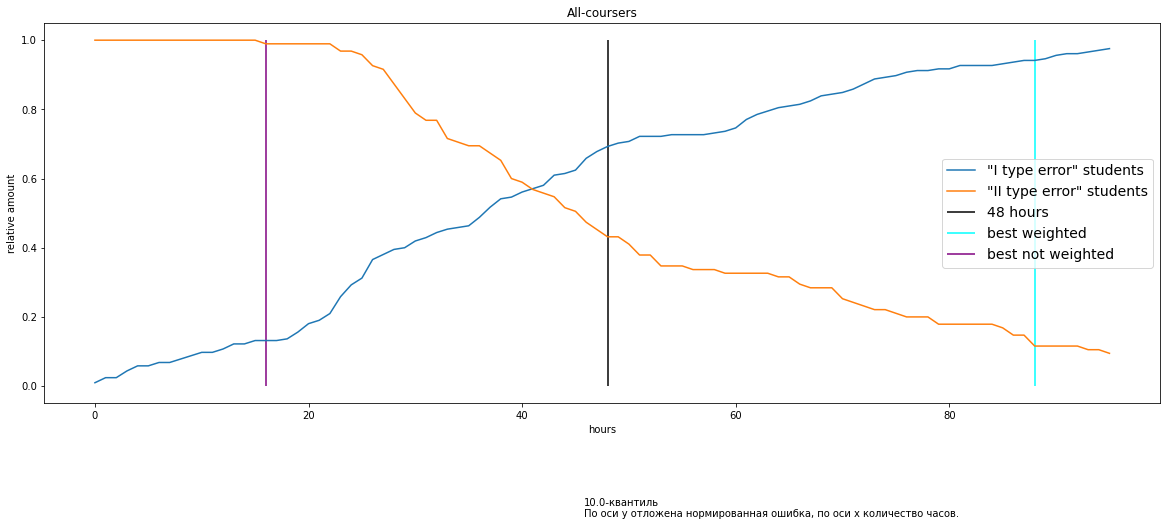

In [6]:
hours_criterion('All','coursers',df=df, show_good_bad=False)

In [7]:

hours = np.arange(0,100)
I_error = []
II_error = []
 
for h in tqdm(hours):
    I_type = 0
    II_type = 0
    for u_id in df['user_id'].unique():
        total = len(df[df['user_id']==u_id])
        greater =  sum((df[df['user_id']==u_id]['hours_diff']>h))/total
        if greater<=0.1 and df[df['user_id']==u_id]['is_achieved'].iloc[0]==0:
            I_type+=1   
        elif greater>0.1 and df[df['user_id']==u_id]['is_achieved'].iloc[0]==1:
            II_type+=1
    I_error.append(I_type)
    II_error.append(II_type)

total_passed = df.groupby(['user_id'])['is_achieved'].min().sum()
total_students = len(df['user_id'].unique())


100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


$ \alpha  : \alpha I_1(48) + (1-\alpha) I_2(48) \rightarrow min_{\alpha}$

In [28]:
size = 1000000
a=0.2
b=0.4
t = np.linspace(a,b,size)
print('Шаг: ',(b-a)/size)
min_h = []
min_dist = 100
nearest_h = 148
nearest_a = 0
for a in tqdm(t):
    w_error = 10000000000
    w_h = None
    for i in range(len(hours)):
        #проверка, что никакая из ошибок не равна 1/0(в абсолютном значении)
        if (I_error[i]!=total_students-total_passed and II_error[i]!=total_passed) and  (II_error[i]!=0 and I_error[i]!=0): 
            if a*I_error[i]+(1-a)*II_error[i]<w_error:
                w_error=a*I_error[i]+(1-a)*II_error[i]
                w_h = hours[i]
    min_h.append(w_h)
    if w_h==48:
        print(f"a = {a}")
        break
    if abs(48-w_h)<min_dist:
        min_dist = abs(48-w_h)
        nearest_h = w_h
        nearest_a = a

print(nearest_h, nearest_a)

Шаг:  2.0000000000000002e-07


100%|██████████| 1000000/1000000 [02:25<00:00, 6850.33it/s]

56 0.33333333333333337


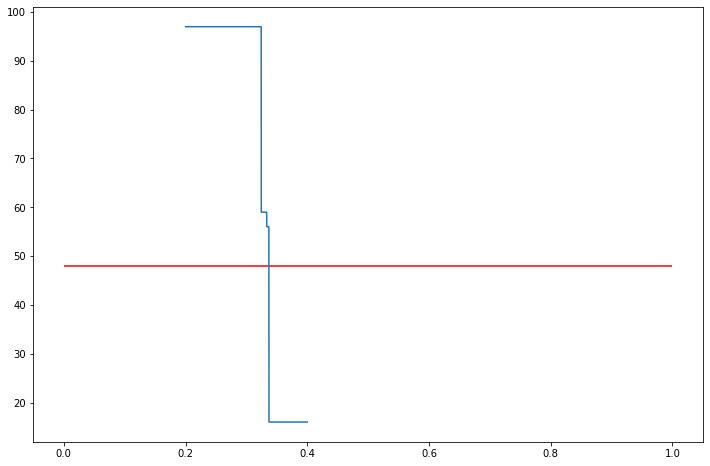

In [26]:
plt.figure(figsize=(12,8))
plt.plot(t,min_h)
plt.hlines(48,0,1,'r')
plt.show()

Кажется $\alpha = \dfrac{1}{3}$

In [27]:
print(I_error[48], II_error[48])

142 41


Подобрать такие веса, что 48 -- оптимальное время
Посмотреть на количество человек в для каждой границе 

100%|██████████| 96/96 [00:38<00:00,  2.50it/s]


Минимальное время проверки: 0 часов, максимальное время проверки 2536 часов
Лучшее "невзвешенное" время: 7 (ошибка 139, из них 46 первого рода), лучшее взвешенное время: 24 (ошибка 0.9360718870346598, из этого 0.8097560975609757 первого рода (166)
Ошибка для 48 часов: 201, из них 200 первого рода,  взвешенная: 0.9861360718870347


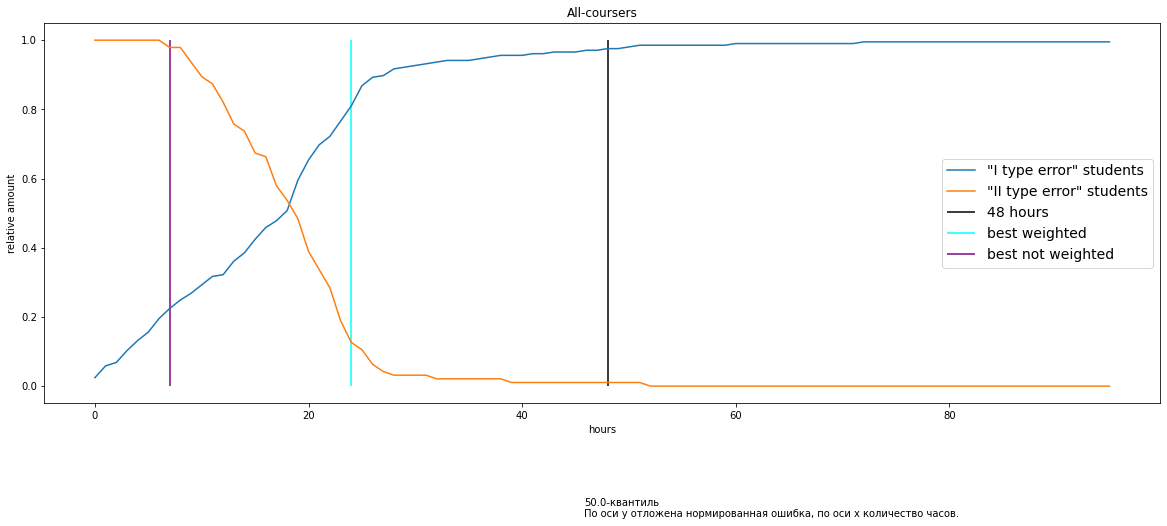

In [8]:
hours_criterion('All','coursers',df=df, show_good_bad=False, fraction=0.5)

## Полные данные

In [62]:
subjects = ['math','physics','linguo']
coursers = [['293','294','295'], ['345','346'],['267','268']]
df = pd.DataFrame()
for s in enumerate(subjects):
        for c in coursers[s[0]]:
            tmp_df = prepare_dataframe(folder='courses_with_manual_check',subject = s[1],course_id = c)
            for i in tmp_df['user_id']:
                try:
                    if i in df['user_id']:
                        print('Alarm')
                except:
                    pass
            df=df.append(tmp_df, ignore_index=True)
new_coursers_id = [370,67,71,76,84,226,231,233,251,252,259,307,318]
for ID in new_coursers_id:
    tmp_df = prepare_dataframe(folder='new_courses',course_id = str(ID))
    for i in tmp_df['user_id']:
                try:
                    if i in df['user_id']:
                        print('Alarm')
                except:
                    pass
    df=df.append(tmp_df, ignore_index=True)
old_courses = [7,6,23,24,25,26,27,28,29,30,31,32,33,36,40,41,42,45,48,49,50,52,53,54,60]
for ID in old_courses:
    tmp_df = prepare_dataframe(folder='old_courses_with_manual_check',course_id = str(ID))
    for i in tmp_df['user_id']:
                try:
                    if i in df['user_id']:
                        print('Alarm')
                except:
                    pass
    df=df.append(tmp_df, ignore_index=True)
print
df = df.sort_values(by = ['user_id', 'review_time'])
df= df.drop(columns=['size_of_answer','element_progress_id','size_of_review',	'tries_count',	'review_time',	'id_from_sl',	'course_element_id'])
df.reset_index(drop=True)
df['unique_id']=df['user_id'].astype(str)+'_'+df['course_module_id'].astype(str)
df.drop(columns=['user_id','id'], inplace=True)
df.sort_values(by='unique_id').head(20)

,hours_diff,course_module_id,is_achieved,unique_id
17500,124.0,2610,0,100119700110016452_2610
17498,157.0,2610,0,100119700110016452_2610
17499,168.0,2610,0,100119700110016452_2610
17501,40.0,2610,0,100119700110016452_2610
17504,24.0,2610,0,100119700110016452_2610
17502,42.0,2610,0,100119700110016452_2610
17503,14.0,2610,0,100119700110016452_2610
7951,45.0,2715,1,100119700110094008_2715
7950,15.0,2715,1,100119700110094008_2715
7948,40.0,2715,1,100119700110094008_2715


In [64]:
df.shape

(43339, 4)

100%|██████████| 96/96 [41:45<00:00, 26.10s/it]


Минимальное время проверки: 0.0 часов, максимальное время проверки 2536.0 часов
Лучшее "невзвешенное" время: 9 (ошибка 524, из них 63 первого рода), лучшее взвешенное время: 61 (ошибка 0.9795802449242668, из этого 0.6757009345794392 первого рода (723)
Ошибка для 48 часов: 792, из них 579 первого рода,  взвешенная: 1.000173219465034


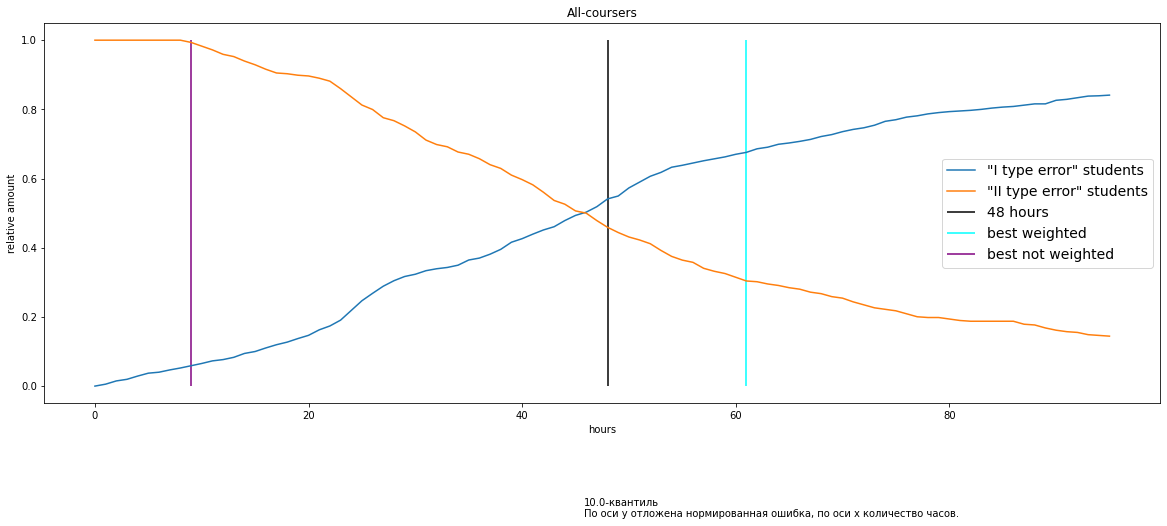

In [66]:
hours_criterion('All','coursers',df=df, show_good_bad=False)

## Современные